# 🍔👁 Food Vision: fine tunning Efficentnet with food_101 dataset

In these notebook I`m going to build a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data (7575 training images and 2525 testing images). After that, I'm going to reproduce the same model with all of the data from the Food101 dataset (7575 training images and 25,250 testing images).

The goal to achive for these project is **beat [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

In thse project you can see the following steps:
- 1. Creation of a small CNN to see how they works
- 2. Transfer Learning with the [EfficientNet](https://arxiv.org/abs/1905.11946) model, a state of the art computer vision architecture trained with [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks. In these case, I'm going to use the 10% of the data of the Food_101 dataset.
- 3. Fine tune the [EfficientNet](https://arxiv.org/abs/1905.11946) model with 10 % of the data.
- 4. Develop the same EfficentNet model as above but with the **100% of the Food_101 dataset**.


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-11-25 20:29:24.176086


- In the repository you can download the *helper_functions.py* file, with developed functions that are so useful for these and other projects of Convolutional Neural Networks

In [6]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/Garcialejan/Computer_vision_food_classification/refs/heads/main/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [47]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import view_random_image, plot_loss_curves, compare_historys, walk_through_dir, load_and_prep_image

- Now, I'm going to import some of the modules that we need to run the code, check the tensorflow version and check if we are using the GPU for run our models.

In [12]:
import tensorflow as tf

In [13]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [14]:
# Get GPU name
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Ti (UUID: GPU-0cb8d0d0-b8f3-ea57-552f-290eacf87dec)


# Models with 10 % of the data

## 1. Loading the data.

In [15]:
train_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train"
test_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test"

In [16]:
walk_through_dir("/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/")

There are 2 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/'.
There are 101 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 i

Image shape: (512, 512, 3)


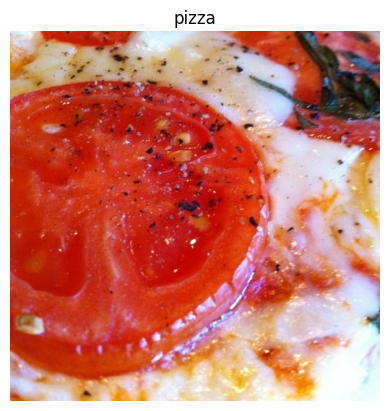

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image_direct(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + "/" +target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

img = view_random_image_direct(target_dir=train_dir, target_class="pizza")

In [52]:
img

array([[[253, 255, 250],
        [253, 255, 250],
        [253, 255, 250],
        ...,
        [ 22,  19,  30],
        [ 21,  19,  30],
        [ 22,  21,  29]],

       [[253, 255, 250],
        [253, 255, 250],
        [253, 255, 250],
        ...,
        [ 23,  21,  34],
        [ 22,  20,  31],
        [ 22,  22,  32]],

       [[253, 255, 250],
        [253, 255, 250],
        [253, 255, 250],
        ...,
        [ 20,  22,  37],
        [ 19,  21,  34],
        [ 19,  21,  34]],

       ...,

       [[ 63,  56,  28],
        [ 63,  56,  28],
        [ 62,  55,  27],
        ...,
        [ 79, 104, 111],
        [119, 144, 151],
        [137, 164, 171]],

       [[ 64,  57,  29],
        [ 65,  58,  30],
        [ 63,  56,  28],
        ...,
        [130, 154, 154],
        [184, 208, 208],
        [194, 220, 217]],

       [[ 60,  53,  25],
        [ 63,  56,  28],
        [ 64,  57,  29],
        ...,
        [165, 190, 186],
        [199, 224, 218],
        [182, 207, 201]]

- Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`
- All of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.
- To work with normalize data, we are going to use one of the most common preprocessing steps for working with images, which is to **scale** (also referred to as **normalize**) the pixel values by dividing the image arrays by 255.

- Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

In [53]:
# Create data inputs using the image_dataset_from_directory 

IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Classification problem
                                                                            batch_size=32) # To avoid memory problems

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [54]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

- The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

In [55]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## 1.1 Adding data augmentation and normalize images

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar. Doing this simulates the kind of data a model might be used on in the real world.

- To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

In [44]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # layers.Rescaling(1./255) # When we use transfer learning or fine tunnning we must remove this part 
], name ="data_augmentation")

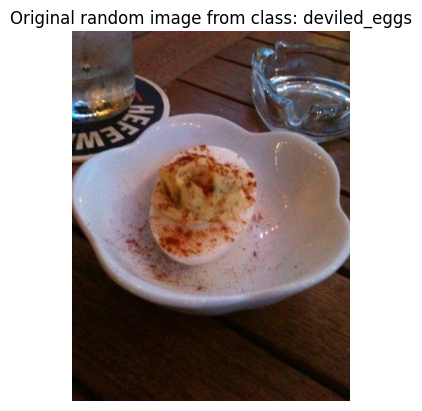

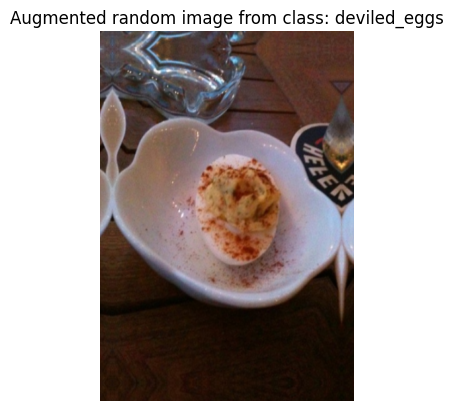

In [57]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_10_percent.class_names) # choose a random class
target_dir = train_dir + "/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image

plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## 2. Creation of the first CNN for tests

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


# Set random seed to compare future models
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = Sequential([
  Conv2D(filters = 10,
         kernel_size = (3, 3),
         activation = "relu",
         input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(pool_size = 2),
  Conv2D(10, 3, activation = "relu"),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(pool_size = 2),
  Flatten(),
  Dense(len(train_data_10_percent.class_names), activation='softmax') # Same hidden units as the output classes and 'softmax' activation
  ])

# Compile the model
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

ValueError: Shapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 101) for variable path='sequential_2/dense_2/kernel'

In [ ]:
# Fit the model
history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=len(test_data_10_percent)*0.3) # reduce the validation steps to increase the model fitting

In [ ]:
model_1.evaluate(test_data_10_percent)

In [ ]:
plot_loss_curves(history_1)